In [1]:
#Exploring the concept of taking two data frames from two seperate queries and applying RITA calculations
## C2 Beacons found at 192.168.120.158 on port 443 and 80 communicating with 192.168.128.50


#Note: Need to figure out how to filter timestamps.

In [2]:
#Elasticsearch connector
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
import eland as ed
#Data manipulation
import pandas as pd
from pandas.io.json import json_normalize
import json
import re
import eland as ed
import numpy as np
import matplotlib.pyplot as plt
import math
import networkx as nx
import ipaddress
from collections import Counter
import networkx.algorithms.community as nxcom
from datetime import datetime
# Disable warnings"
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
es = Elasticsearch(['https://192.168.1.181:9200'], timeout=30, max_retries=10, retry_on_timeout=True,                  
ca_certs=False,verify_certs=False, http_auth=('jupyter','password'))

# defining the search statement to get all records in an index
searchContext = Search(using=es, index='*:so-*', doc_type='doc')
es.info()

ObjectApiResponse({'name': 'voodoo-onion', 'cluster_name': 'voodoo-onion', 'cluster_uuid': 'dP1VycCSTQ2EPeCVxQ25GA', 'version': {'number': '7.16.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '2b937c44140b6559905130a8650c64dbd0879cfb', 'build_date': '2021-12-18T19:42:46.604893745Z', 'build_snapshot': False, 'lucene_version': '8.10.1', 'minimum_wire_compatibility_version': '6.8.0', 'minimum_index_compatibility_version': '6.0.0-beta1'}, 'tagline': 'You Know, for Search'})

In [4]:
#query_since_ts = "2021-12-30"
#body_filter = '{"query":{"bool":{"filter":[{"range":{"@timestamp":{"gte": ' + str(query_since_ts) + ' }}}]}},"size=10000":[{"@timestamp":{"order":"desc"}}]}'
#body_filter = '{"query":{"bool":{"filter":[{"range":{"@timestamp":{"gte":"2021-21-30","lte":"2021-12-31"}}}]}},"size=10000":[{"@timestamp":{"order":"desc"}}]}'

body_filter = '{"query":{"bool":{"must":[],"filter":[{"range":{"@timestamp":{"format":"strict_date_optional_time","gte":"2021-12-30","lte":"2022-01-01"}}}]}'

In [5]:
#Firewall 192.168.1.154

s1 = searchContext.query('query_string', query='(destination.port:443) AND NOT source.ip:(192.168.1.154 OR 192.168.1.220)')


In [6]:
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 600)
pd.set_option("display.max_columns", None)


In [7]:
#data frame 1 for s1 which is search query 1
response = s1.execute()
df1 = pd.DataFrame(columns=['ts','source.ip','destination.ip','destination.port'])
if response.success():
    for d in s1[:10000]:
        try:
            df1 = df1.append({'ts' : d['@timestamp'], 'source.ip' : d['source']['ip'], 'destination.ip' : d['destination']['ip'], 'destination.port': d['destination']['port']}, ignore_index=True)
        except KeyError:
            pass       

display(df1)

df1.info()

,ts,source.ip,destination.ip,destination.port
0,2021-12-29T22:25:30.117Z,192.168.128.50,192.168.120.158,443
1,2021-12-29T22:23:29.880Z,192.168.128.50,192.168.120.158,443
2,2021-12-29T22:21:29.647Z,192.168.128.50,192.168.120.158,443
3,2021-12-29T22:19:29.627Z,192.168.128.50,192.168.120.158,443
4,2021-12-29T22:17:29.393Z,192.168.128.50,192.168.120.158,443
...,...,...,...,...
9995,2021-12-31T06:03:48.724Z,192.168.128.26,52.153.255.201,443
9996,2021-12-31T06:03:48.691Z,192.168.128.26,52.153.255.201,443
9997,2021-12-31T06:01:15.621Z,192.168.128.50,192.168.120.158,443
9998,2021-12-31T06:01:04.216Z,192.168.128.26,20.189.173.15,443


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ts                10000 non-null  object
 1   source.ip         10000 non-null  object
 2   destination.ip    10000 non-null  object
 3   destination.port  10000 non-null  object
dtypes: object(4)
memory usage: 312.6+ KB


In [8]:
s2 = searchContext.query('query_string', query='(destination.port:80 and 53) AND NOT source.ip:(192.168.1.154 OR 192.168.1.220)')

In [9]:
#data frame 2 for s2 which is search query 2
response = s2.execute()
df2 = pd.DataFrame(columns=['ts','source.ip','destination.ip','destination.port'])
if response.success():
    for d in s2[:10000]:
        try:
            df2 = df2.append({'ts' : d['@timestamp'], 'source.ip' : d['source']['ip'], 'destination.ip' : d['destination']['ip'], 'destination.port': d['destination']['port']}, ignore_index=True)
        except KeyError:
            pass       

display(df2)

df2.info()

,ts,source.ip,destination.ip,destination.port
0,2021-12-30T22:53:59.996Z,192.168.128.50,192.168.120.158,80
1,2021-12-30T23:53:17.674Z,192.168.128.50,192.168.120.158,80
2,2021-12-30T21:53:56.547Z,192.168.128.50,192.168.120.158,80
3,2021-12-30T21:53:02.643Z,192.168.128.50,192.168.120.158,80
4,2021-12-30T22:53:08.969Z,192.168.128.50,192.168.120.158,80
...,...,...,...,...
279,2022-01-01T18:53:59.501Z,192.168.120.158,192.168.128.7,56053
280,2022-01-01T18:53:59.501Z,192.168.120.158,192.168.128.7,56053
281,2022-01-01T18:53:59.501Z,192.168.120.158,192.168.128.7,56053
282,2022-01-01T18:53:59.501Z,192.168.120.158,192.168.128.7,56053


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ts                284 non-null    object
 1   source.ip         284 non-null    object
 2   destination.ip    284 non-null    object
 3   destination.port  284 non-null    object
dtypes: object(4)
memory usage: 9.0+ KB


In [10]:
# assign field/column names to variables
f_timestamp = 'ts'
f_src_ip = 'source.ip'
f_dst_ip = 'destination.ip'
f_dst_port = 'destination.port'
f_delimiter = '\t'


In [11]:
df1['ts'] = pd.to_datetime(df1['ts'],infer_datetime_format=True)
df1.head(10)

,ts,source.ip,destination.ip,destination.port
0,2021-12-29 22:25:30.117000+00:00,192.168.128.50,192.168.120.158,443
1,2021-12-29 22:23:29.880000+00:00,192.168.128.50,192.168.120.158,443
2,2021-12-29 22:21:29.647000+00:00,192.168.128.50,192.168.120.158,443
3,2021-12-29 22:19:29.627000+00:00,192.168.128.50,192.168.120.158,443
4,2021-12-29 22:17:29.393000+00:00,192.168.128.50,192.168.120.158,443
5,2021-12-29 22:15:29.032000+00:00,192.168.128.50,192.168.120.158,443
6,2021-12-29 22:13:28.874000+00:00,192.168.128.50,192.168.120.158,443
7,2021-12-29 22:11:28.594000+00:00,192.168.128.50,192.168.120.158,443
8,2021-12-29 22:09:28.216000+00:00,192.168.128.50,192.168.120.158,443
9,2021-12-29 22:07:27.924000+00:00,192.168.128.50,192.168.120.158,443


In [12]:
df2['ts'] = pd.to_datetime(df2['ts'],infer_datetime_format=True)
df2.head(10)

,ts,source.ip,destination.ip,destination.port
0,2021-12-30 22:53:59.996000+00:00,192.168.128.50,192.168.120.158,80
1,2021-12-30 23:53:17.674000+00:00,192.168.128.50,192.168.120.158,80
2,2021-12-30 21:53:56.547000+00:00,192.168.128.50,192.168.120.158,80
3,2021-12-30 21:53:02.643000+00:00,192.168.128.50,192.168.120.158,80
4,2021-12-30 22:53:08.969000+00:00,192.168.128.50,192.168.120.158,80
5,2021-12-30 20:53:45.940000+00:00,192.168.128.50,192.168.120.158,80
6,2021-12-30 19:53:49.912000+00:00,192.168.128.50,192.168.120.158,80
7,2021-12-30 20:29:40.071000+00:00,192.168.128.50,192.168.128.25,53
8,2021-12-31 17:53:38.920000+00:00,192.168.128.50,192.168.120.158,443
9,2021-12-31 16:53:20.559000+00:00,192.168.128.50,192.168.120.158,443


In [13]:
# Merge the two to create our final dataframe
df = pd.concat([df1, df2], ignore_index=True)
print(df.head(5))
print(df.tail(5))

                                ts       source.ip   destination.ip  \
0 2021-12-29 22:25:30.117000+00:00  192.168.128.50  192.168.120.158   
1 2021-12-29 22:23:29.880000+00:00  192.168.128.50  192.168.120.158   
2 2021-12-29 22:21:29.647000+00:00  192.168.128.50  192.168.120.158   
3 2021-12-29 22:19:29.627000+00:00  192.168.128.50  192.168.120.158   
4 2021-12-29 22:17:29.393000+00:00  192.168.128.50  192.168.120.158   

  destination.port  
0              443  
1              443  
2              443  
3              443  
4              443  
                                    ts        source.ip destination.ip  \
10279 2022-01-01 18:53:59.501000+00:00  192.168.120.158  192.168.128.7   
10280 2022-01-01 18:53:59.501000+00:00  192.168.120.158  192.168.128.7   
10281 2022-01-01 18:53:59.501000+00:00  192.168.120.158  192.168.128.7   
10282 2022-01-01 18:53:59.501000+00:00  192.168.120.158  192.168.128.7   
10283 2022-01-01 18:53:59.496000+00:00  192.168.120.158  192.168.128.7   

  

In [14]:

columns_to_filter = [f_timestamp, f_src_ip, f_dst_ip, f_dst_port,]
columns_to_groupby = [f_src_ip, f_dst_ip, f_dst_port,]
# columns to display after the analysis
columns_to_display = ['tsScore','conn_count',f_src_ip,f_dst_ip,f_dst_port,'deltas']

In [15]:
# If you have a large dateset, using groupby and aggregate(list) might be slow. Consider using dask
df = df.groupby(columns_to_groupby).agg(list)
df.head(50)

ts
source.ip       destination.ip destination.port                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
192.168.1.149   208.91.0.89    443                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                [2022-01-02 18:13:55.750000+00:00, 2022-01-02 18:10:35.848000+00:00, 2022-01-02 18:14:05.657000+00:00]
192.168.1.180   52.46.142.109  443                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  [2022-01-02 20:33:52.832000+00:00, 2022-01-02 19:39:47.281000+00:00]
192.168.1.203   52.46.148.49   443                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    [2021-12-30 06:19:39.504000+00:00]
                52.94.232.230  443                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  [2022-01-01 06:46:02.222000+00:00, 2022-01-01 03:08:11.453000+00:00]
                52.94.241.196  443                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    [2021-12-31 06:33:06.902000+00:00]
192.168.1.226   104.42.50.130  443                                                                     

In [16]:
df.reset_index(inplace=True)
df.head(5)

,source.ip,destination.ip,destination.port,ts
0,192.168.1.149,208.91.0.89,443,"[2022-01-02 18:13:55.750000+00:00, 2022-01-02 18:10:35.848000+00:00, 2022-01-02 18:14:05.657000+00:00]"
1,192.168.1.180,52.46.142.109,443,"[2022-01-02 20:33:52.832000+00:00, 2022-01-02 19:39:47.281000+00:00]"
2,192.168.1.203,52.46.148.49,443,[2021-12-30 06:19:39.504000+00:00]
3,192.168.1.203,52.94.232.230,443,"[2022-01-01 06:46:02.222000+00:00, 2022-01-01 03:08:11.453000+00:00]"
4,192.168.1.203,52.94.241.196,443,[2021-12-31 06:33:06.902000+00:00]


In [17]:
# create a new column 'conn_count', and for each row in the 'ts' column, apply a function and assign the returned value to the 'conn_count' column
df['conn_count'] = df[f_timestamp].apply(lambda x: len(x))
df.head(2)

,source.ip,destination.ip,destination.port,ts,conn_count
0,192.168.1.149,208.91.0.89,443,"[2022-01-02 18:13:55.750000+00:00, 2022-01-02 18:10:35.848000+00:00, 2022-01-02 18:14:05.657000+00:00]",3
1,192.168.1.180,52.46.142.109,443,"[2022-01-02 20:33:52.832000+00:00, 2022-01-02 19:39:47.281000+00:00]",2


In [18]:
#Filter out traffic where the connection count is quite small
df = df.loc[df['conn_count'] > 100]
df.shape

(16, 5)

In [19]:
df[f_timestamp] = df[f_timestamp].apply(lambda x: sorted(x))
df.head()

,source.ip,destination.ip,destination.port,ts,conn_count
106,192.168.128.10,52.167.17.97,443,"[2021-12-29 20:42:04.645000+00:00, 2021-12-29 20:42:04.680000+00:00, 2021-12-29 21:17:38.080000+00:00, 2021-12-29 21:17:38.286000+00:00, 2021-12-29 21:17:38.316000+00:00, 2021-12-29 21:42:05.341000+00:00, 2021-12-29 22:00:42.333000+00:00, 2021-12-30 00:30:57.099000+00:00, 2021-12-30 01:27:07.164000+00:00, 2021-12-30 01:42:07.376000+00:00, 2021-12-30 01:42:07.407000+00:00, 2021-12-30 02:42:07.805000+00:00, 2021-12-30 02:42:07.836000+00:00, 2021-12-30 02:42:23.562000+00:00, 2021-12-30 02:42:23.593000+00:00, 2021-12-30 03:26:07.246000+00:00, 2021-12-30 03:26:07.955000+00:00, 2021-12-30 03:42:...",129
107,192.168.128.10,52.167.249.196,443,"[2021-12-29 21:12:05.088000+00:00, 2021-12-29 22:12:05.547000+00:00, 2021-12-29 22:12:05.578000+00:00, 2021-12-30 00:24:36.128000+00:00, 2021-12-30 00:24:36.163000+00:00, 2021-12-30 00:24:36.772000+00:00, 2021-12-30 00:42:06.786000+00:00, 2021-12-30 02:56:56.019000+00:00, 2021-12-30 03:12:08.079000+00:00, 2021-12-30 03:12:08.111000+00:00, 2021-12-30 05:42:09.080000+00:00, 2021-12-30 06:42:09.596000+00:00, 2021-12-30 07:42:09.871000+00:00, 2021-12-30 07:42:09.902000+00:00, 2021-12-30 07:57:10.233000+00:00, 2021-12-30 08:06:26.685000+00:00, 2021-12-30 08:06:26.720000+00:00, 2021-12-30 08:06:...",170
256,192.168.128.11,52.167.17.97,443,"[2021-12-29 20:44:14.964000+00:00, 2021-12-29 21:44:15.401000+00:00, 2021-12-29 21:44:15.483000+00:00, 2021-12-29 22:14:15.739000+00:00, 2021-12-29 23:44:16.656000+00:00, 2021-12-30 00:44:16.900000+00:00, 2021-12-30 00:44:16.930000+00:00, 2021-12-30 01:14:17.288000+00:00, 2021-12-30 01:14:17.319000+00:00, 2021-12-30 01:35:10.403000+00:00, 2021-12-30 01:35:10.438000+00:00, 2021-12-30 01:35:10.534000+00:00, 2021-12-30 01:35:10.660000+00:00, 2021-12-30 02:44:18.067000+00:00, 2021-12-30 03:19:08.314000+00:00, 2021-12-30 03:19:08.349000+00:00, 2021-12-30 03:19:08.610000+00:00, 2021-12-30 03:19:...",167
257,192.168.128.11,52.167.249.196,443,"[2021-12-29 20:28:05.067000+00:00, 2021-12-29 20:28:06.566000+00:00, 2021-12-29 22:44:16.007000+00:00, 2021-12-29 23:14:16.338000+00:00, 2021-12-30 00:42:46.329000+00:00, 2021-12-30 00:42:46.517000+00:00, 2021-12-30 01:44:17.537000+00:00, 2021-12-30 01:44:17.568000+00:00, 2021-12-30 02:14:17.805000+00:00, 2021-12-30 04:14:18.759000+00:00, 2021-12-30 04:14:18.789000+00:00, 2021-12-30 04:44:19.148000+00:00, 2021-12-30 04:44:19.179000+00:00, 2021-12-30 04:51:07.484000+00:00, 2021-12-30 04:51:07.520000+00:00, 2021-12-30 04:51:07.748000+00:00, 2021-12-30 04:51:07.778000+00:00, 2021-12-30 06:45:...",142
315,192.168.128.15,65.55.44.109,443,"[2021-12-29 19:59:45.782000+00:00, 2021-12-29 20:29:45.846000+00:00, 2021-12-29 21:29:45.876000+00:00, 2021-12-29 21:29:45.905000+00:00, 2021-12-29 21:59:45.897000+00:00, 2021-12-29 22:20:52.032000+00:00, 2021-12-29 22:20:52.129000+00:00, 2021-12-29 22:20:52.129000+00:00, 2021-12-29 22:59:45.975000+00:00, 2021-12-29 23:29:46.033000+00:00, 2021-12-29 23:59:46.064000+00:00, 2021-12-30 00:29:46.113000+00:00, 2021-12-30 00:59:46.141000+00:00, 2021-12-30 00:59:46.204000+00:00, 2021-12-30 01:29:46.213000+00:00, 2021-12-30 02:29:46.268000+00:00, 2021-12-30 02:29:46.299000+00:00, 2021-12-30 02:59:...",222


In [20]:
# Convert list into a Series object, get time delta, convert the result back into a list and assign it to the 'deltas' column
df['deltas'] = df[f_timestamp].apply(lambda x: pd.Series(x).diff().dt.seconds.dropna().tolist())
df.head(2)

,source.ip,destination.ip,destination.port,ts,conn_count,deltas
106,192.168.128.10,52.167.17.97,443,"[2021-12-29 20:42:04.645000+00:00, 2021-12-29 20:42:04.680000+00:00, 2021-12-29 21:17:38.080000+00:00, 2021-12-29 21:17:38.286000+00:00, 2021-12-29 21:17:38.316000+00:00, 2021-12-29 21:42:05.341000+00:00, 2021-12-29 22:00:42.333000+00:00, 2021-12-30 00:30:57.099000+00:00, 2021-12-30 01:27:07.164000+00:00, 2021-12-30 01:42:07.376000+00:00, 2021-12-30 01:42:07.407000+00:00, 2021-12-30 02:42:07.805000+00:00, 2021-12-30 02:42:07.836000+00:00, 2021-12-30 02:42:23.562000+00:00, 2021-12-30 02:42:23.593000+00:00, 2021-12-30 03:26:07.246000+00:00, 2021-12-30 03:26:07.955000+00:00, 2021-12-30 03:42:...",129,"[0.0, 2133.0, 0.0, 0.0, 1467.0, 1116.0, 9014.0, 3370.0, 900.0, 0.0, 3600.0, 0.0, 15.0, 0.0, 2623.0, 0.0, 960.0, 0.0, 2580.0, 0.0, 0.0, 1018.0, 3714.0, 0.0, 998.0, 9687.0, 1800.0, 0.0, 12601.0, 6301.0, 900.0, 0.0, 3021.0, 579.0, 0.0, 3308.0, 0.0, 0.0, 0.0, 291.0, 5400.0, 9901.0, 2700.0, 0.0, 9000.0, 0.0, 11701.0, 5604.0, 1.0, 6096.0, 3600.0, 1378.0, 0.0, 6722.0, 35.0, 994.0, 0.0, 7071.0, 5400.0, 0.0, 1032.0, 0.0, 4368.0, 3749.0, 0.0, 1651.0, 3600.0, 1800.0, 0.0, 1800.0, 0.0, 3600.0, 873.0, 0.0, 6326.0, 0.0, 3600.0, 0.0, 10801.0, 10801.0, 0.0, 49.0, 0.0, 10752.0, 3600.0, 0.0, 7200.0, 2245.0,..."
107,192.168.128.10,52.167.249.196,443,"[2021-12-29 21:12:05.088000+00:00, 2021-12-29 22:12:05.547000+00:00, 2021-12-29 22:12:05.578000+00:00, 2021-12-30 00:24:36.128000+00:00, 2021-12-30 00:24:36.163000+00:00, 2021-12-30 00:24:36.772000+00:00, 2021-12-30 00:42:06.786000+00:00, 2021-12-30 02:56:56.019000+00:00, 2021-12-30 03:12:08.079000+00:00, 2021-12-30 03:12:08.111000+00:00, 2021-12-30 05:42:09.080000+00:00, 2021-12-30 06:42:09.596000+00:00, 2021-12-30 07:42:09.871000+00:00, 2021-12-30 07:42:09.902000+00:00, 2021-12-30 07:57:10.233000+00:00, 2021-12-30 08:06:26.685000+00:00, 2021-12-30 08:06:26.720000+00:00, 2021-12-30 08:06:...",170,"[3600.0, 0.0, 7950.0, 0.0, 0.0, 1050.0, 8089.0, 912.0, 0.0, 9000.0, 3600.0, 3600.0, 0.0, 900.0, 556.0, 0.0, 0.0, 0.0, 2364.0, 14.0, 3546.0, 0.0, 0.0, 3419.0, 1111.0, 0.0, 687.0, 0.0, 1800.0, 2111.0, 10490.0, 0.0, 0.0, 9000.0, 0.0, 671.0, 2929.0, 3600.0, 3600.0, 1800.0, 0.0, 2182.0, 0.0, 3218.0, 0.0, 3600.0, 0.0, 3600.0, 0.0, 3557.0, 0.0, 0.0, 0.0, 41.0, 0.0, 3600.0, 1104.0, 0.0, 695.0, 0.0, 1800.0, 0.0, 3229.0, 0.0, 0.0, 0.0, 369.0, 0.0, 61.0, 0.0, 3539.0, 10749.0, 0.0, 3651.0, 0.0, 967.0, 2632.0, 0.0, 3600.0, 0.0, 3531.0, 68.0, 2028.0, 0.0, 0.0, 0.0, 0.0, 7427.0, 0.0, 0.0, 1345.0, 10490.0..."


In [21]:
df['tsLow'] = df['deltas'].apply(lambda x: np.percentile(np.array(x), 20))
df['tsMid'] = df['deltas'].apply(lambda x: np.percentile(np.array(x), 50))
df['tsHigh'] = df['deltas'].apply(lambda x: np.percentile(np.array(x), 80))
df['tsBowleyNum'] = df['tsLow'] + df['tsHigh'] - 2*df['tsMid']
df['tsBowleyDen'] = df['tsHigh'] - df['tsLow']
df['tsSkew'] = df[['tsLow','tsMid','tsHigh','tsBowleyNum','tsBowleyDen']].apply(
    lambda x: x['tsBowleyNum'] / x['tsBowleyDen'] if x['tsBowleyDen'] != 0 and x['tsMid'] != x['tsLow'] and x['tsMid'] != x['tsHigh'] else 0.0, axis=1
    )
df['tsMadm'] = df['deltas'].apply(lambda x: np.median(np.absolute(np.array(x) - np.median(np.array(x)))))
df['tsConnDiv'] = df[f_timestamp].apply(lambda x: (x[-1].to_pydatetime() - x[0].to_pydatetime()).seconds / 45)

In [22]:
df.head(3)

,source.ip,destination.ip,destination.port,ts,conn_count,deltas,tsLow,tsMid,tsHigh,tsBowleyNum,tsBowleyDen,tsSkew,tsMadm,tsConnDiv
106,192.168.128.10,52.167.17.97,443,"[2021-12-29 20:42:04.645000+00:00, 2021-12-29 20:42:04.680000+00:00, 2021-12-29 21:17:38.080000+00:00, 2021-12-29 21:17:38.286000+00:00, 2021-12-29 21:17:38.316000+00:00, 2021-12-29 21:42:05.341000+00:00, 2021-12-29 22:00:42.333000+00:00, 2021-12-30 00:30:57.099000+00:00, 2021-12-30 01:27:07.164000+00:00, 2021-12-30 01:42:07.376000+00:00, 2021-12-30 01:42:07.407000+00:00, 2021-12-30 02:42:07.805000+00:00, 2021-12-30 02:42:07.836000+00:00, 2021-12-30 02:42:23.562000+00:00, 2021-12-30 02:42:23.593000+00:00, 2021-12-30 03:26:07.246000+00:00, 2021-12-30 03:26:07.955000+00:00, 2021-12-30 03:42:...",129,"[0.0, 2133.0, 0.0, 0.0, 1467.0, 1116.0, 9014.0, 3370.0, 900.0, 0.0, 3600.0, 0.0, 15.0, 0.0, 2623.0, 0.0, 960.0, 0.0, 2580.0, 0.0, 0.0, 1018.0, 3714.0, 0.0, 998.0, 9687.0, 1800.0, 0.0, 12601.0, 6301.0, 900.0, 0.0, 3021.0, 579.0, 0.0, 3308.0, 0.0, 0.0, 0.0, 291.0, 5400.0, 9901.0, 2700.0, 0.0, 9000.0, 0.0, 11701.0, 5604.0, 1.0, 6096.0, 3600.0, 1378.0, 0.0, 6722.0, 35.0, 994.0, 0.0, 7071.0, 5400.0, 0.0, 1032.0, 0.0, 4368.0, 3749.0, 0.0, 1651.0, 3600.0, 1800.0, 0.0, 1800.0, 0.0, 3600.0, 873.0, 0.0, 6326.0, 0.0, 3600.0, 0.0, 10801.0, 10801.0, 0.0, 49.0, 0.0, 10752.0, 3600.0, 0.0, 7200.0, 2245.0,...",0.0,1074.0,4751.0,2603.0,4751.0,0.547885,1074.0,1878.977778
107,192.168.128.10,52.167.249.196,443,"[2021-12-29 21:12:05.088000+00:00, 2021-12-29 22:12:05.547000+00:00, 2021-12-29 22:12:05.578000+00:00, 2021-12-30 00:24:36.128000+00:00, 2021-12-30 00:24:36.163000+00:00, 2021-12-30 00:24:36.772000+00:00, 2021-12-30 00:42:06.786000+00:00, 2021-12-30 02:56:56.019000+00:00, 2021-12-30 03:12:08.079000+00:00, 2021-12-30 03:12:08.111000+00:00, 2021-12-30 05:42:09.080000+00:00, 2021-12-30 06:42:09.596000+00:00, 2021-12-30 07:42:09.871000+00:00, 2021-12-30 07:42:09.902000+00:00, 2021-12-30 07:57:10.233000+00:00, 2021-12-30 08:06:26.685000+00:00, 2021-12-30 08:06:26.720000+00:00, 2021-12-30 08:06:...",170,"[3600.0, 0.0, 7950.0, 0.0, 0.0, 1050.0, 8089.0, 912.0, 0.0, 9000.0, 3600.0, 3600.0, 0.0, 900.0, 556.0, 0.0, 0.0, 0.0, 2364.0, 14.0, 3546.0, 0.0, 0.0, 3419.0, 1111.0, 0.0, 687.0, 0.0, 1800.0, 2111.0, 10490.0, 0.0, 0.0, 9000.0, 0.0, 671.0, 2929.0, 3600.0, 3600.0, 1800.0, 0.0, 2182.0, 0.0, 3218.0, 0.0, 3600.0, 0.0, 3600.0, 0.0, 3557.0, 0.0, 0.0, 0.0, 41.0, 0.0, 3600.0, 1104.0, 0.0, 695.0, 0.0, 1800.0, 0.0, 3229.0, 0.0, 0.0, 0.0, 369.0, 0.0, 61.0, 0.0, 3539.0, 10749.0, 0.0, 3651.0, 0.0, 967.0, 2632.0, 0.0, 3600.0, 0.0, 3531.0, 68.0, 2028.0, 0.0, 0.0, 0.0, 0.0, 7427.0, 0.0, 0.0, 1345.0, 10490.0...",0.0,369.0,3600.0,2862.0,3600.0,0.795000,369.0,1601.022222
256,192.168.128.11,52.167.17.97,443,"[2021-12-29 20:44:14.964000+00:00, 2021-12-29 21:44:15.401000+00:00, 2021-12-29 21:44:15.483000+00:00, 2021-12-29 22:14:15.739000+00:00, 2021-12-29 23:44:16.656000+00:00, 2021-12-30 00:44:16.900000+00:00, 2021-12-30 00:44:16.930000+00:00, 2021-12-30 01:14:17.288000+00:00, 2021-12-30 01:14:17.319000+00:00, 2021-12-30 01:35:10.403000+00:00, 2021-12-30 01:35:10.438000+00:00, 2021-12-30 01:35:10.534000+00:00, 2021-12-30 01:35:10.660000+00:00, 2021-12-30 02:44:18.067000+00:00, 2021-12-30 03:19:08.314000+00:00, 2021-12-30 03:19:08.349000+00:00, 2021-12-30 03:19:08.610000+00:00, 2021-12-30 03:19:...",167,"[3600.0, 0.0, 1800.0, 5400.0, 3600.0, 0.0, 1800.0, 0.0, 1253.0, 0.0, 0.0, 0.0, 4147.0, 2090.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1508.0, 4631.0, 769.0, 1800.0, 0.0, 486.0, 373.0, 0.0, 2739.0, 0.0, 60.0, 0.0, 3540.0, 0.0, 4310.0, 14.0, 0.0, 0.0, 2410.0, 4064.0, 0.0, 1800.0, 0.0, 5400.0, 1800.0, 1800.0, 0.0, 0.0, 7200.0, 5401.0, 1800.0, 375.0, 0.0, 3224.0, 4143.0, 0.0, 1257.0, 0.0, 1800.0, 0.0, 6524.0, 1.0, 0.0, 2474.0, 1107.0, 0.0, 691.0, 7200.0, 0.0, 1800.0, 5400.0, 0.0, 0.0, 3600.0, 0.0, 5956.0, 3044.0, 0.0, 3600.0, 0.0, 0.0, 1800.0, 0.0, 3600.0, 1800.0, 0.0, 3600.0, 1800.0, 3600.0, 7201.0, 0.0, 3...",0.0,1191.5,3600.0

In [23]:
df['tsSkewScore'] = 1.0 - abs(df['tsSkew'])
df['tsMadmScore'] = 1.0 - df['tsMadm']/30.0
df['tsMadmScore'] = df['tsMadmScore'].apply(lambda x: 0 if x < 0 else x)
df['tsConnCountScore'] = (df['conn_count']) / df['tsConnDiv']
df['tsConnCountScore'] = df['tsConnCountScore'].apply(lambda x: 1.0 if x > 1.0 else x)
df['tsScore'] = (((df['tsSkewScore'] + df['tsMadmScore'] + df['tsConnCountScore']) / 3.0) * 1000) / 1000
df.sort_values(by= 'tsScore', ascending=False, inplace=True, ignore_index=True)
df[columns_to_display].head(30)

,tsScore,conn_count,source.ip,destination.ip,destination.port,deltas
0,1.000000,110,192.168.128.50,52.251.79.25,443,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]"
1,0.854097,1037,192.168.128.50,192.168.120.158,443,"[120.0, 0.0, 120.0, 0.0, 120.0, 0.0, 120.0, 0.0, 120.0, 0.0, 120.0, 0.0, 120.0, 360.0, 120.0, 120.0, 120.0, 0.0, 120.0, 120.0, 0.0, 120.0, 120.0, 0.0, 120.0, 0.0, 120.0, 0.0, 120.0, 120.0, 360.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 0.0, 240.0, 120.0, 120.0, 120.0, 0.0, 120.0, 120.0, 0.0, 120.0, 120.0, 120.0, 120.0, 0.0, 240.0, 0.0, 240.0, 120.0, 0.0, 240.0, 120.0, 0.0, 120.0, 120.0, 120.0, 0.0, 676.0, 140.0, 0.0, 120.0, 0.0, 120.0, 120.0, 0.0, 120.0, 120.0, 120.0, 120.0, 360.0, 120.0, 120.0, 120.0, 120.0, 120.0, 52027.0, 0.0, 120.0, 0.0, 120.0, 120.0, 120.0, 120.0, 0.0, 120.0, 0.0, 1..."
2,0.693288,149,192.168.128.50,52.153.255.222,443,"[0.0, 71704.0, 0.0, 0.0, 0.0, 3600.0, 0.0, 0.0, 5017.0, 0.0, 0.0, 3600.0, 0.0, 3600.0, 0.0, 3600.0, 0.0, 0.0, 7200.0, 0.0, 0.0, 0.0, 3600.0, 0.0, 3600.0, 0.0, 0.0, 0.0, 3600.0, 0.0, 3600.0, 0.0, 3600.0, 0.0, 3600.0, 0.0, 3600.0, 0.0, 3600.0, 3600.0, 0.0, 3600.0, 0.0, 3600.0, 0.0, 0.0, 3600.0, 0.0, 0.0, 3600.0, 0.0, 0.0, 3600.0, 0.0, 3600.0, 3600.0, 0.0, 358.0, 3241.0, 0.0, 0.0, 3600.0, 0.0, 0.0, 3600.0, 3600.0, 0.0, 0.0, 3600.0, 0.0, 3600.0, 0.0, 0.0, 3600.0, 0.0, 0.0, 0.0, 3600.0, 0.0, 0.0, 3600.0, 3600.0, 0.0, 7200.0, 0.0, 3600.0, 0.0, 0.0, 3600.0, 0.0, 14401.0, 3600.0, 0.0, 7200.0, 3600..."
3,0.691116,135,192.168.128.50,20.81.52.156,443,"[3600.0, 0.0, 0.0, 3600.0, 0.0, 0.0, 3600.0, 3600.0, 0.0, 3600.0, 3600.0, 0.0, 3600.0, 0.0, 0.0, 0.0, 3600.0, 0.0, 0.0, 0.0, 3600.0, 0.0, 0.0, 3600.0, 0.0, 3600.0, 0.0, 0.0, 3600.0, 0.0, 3600.0, 0.0, 3600.0, 0.0, 3600.0, 0.0, 0.0, 3600.0, 0.0, 0.0, 3600.0, 0.0, 7200.0, 0.0, 3600.0, 0.0, 3600.0, 0.0, 0.0, 3600.0, 3600.0, 0.0, 3600.0, 0.0, 0.0, 0.0, 3600.0, 3600.0, 3600.0, 0.0, 3600.0, 0.0, 3600.0, 3600.0, 0.0, 7200.0, 0.0, 0.0, 3600.0, 0.0, 3600.0, 3600.0, 3600.0, 0.0, 3600.0, 3600.0, 0.0, 0.0, 1934.0, 1666.0, 7200.0, 3600.0, 0.0, 3600.0, 3600.0, 0.0, 0.0, 3600.0, 0.0, 3600.0, 0.0, 3600.0, ..."
4,0.531073,1606,192.168.128.50,192.168.120.158,443,"[120.0, 120.0, 121.0, 120.0, 120.0, 120.0, 121.0, 120.0, 120.0, 121.0, 120.0, 120.0, 120.0, 120.0, 121.0, 120.0, 5802.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 0.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 0.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120..."
5,0.504568,142,192.168.128.11,52.167.249.196,443,"[1.0, 8169.0, 1800.0, 5309.0, 0.0, 3691.0, 0.0, 1800.0, 7200.0, 0.0, 1800.0, 0.0, 408.0, 0.0, 0.0, 0.0, 6853.0, 0.0, 1739.0, 3600.0, 1800.0, 859.0, 2740.0, 412.0, 0.0, 1387.0, 0.0, 5400.0, 0.0, 9001.0, 0.0, 5645.0, 1.0, 1555.0, 0.0, 606.0, 0.0, 3882.0, 0.0, 0.0, 3101.0, 3210.0, 1800.0, 0.0, 4297.0, 0.0, 0.0, 2903.0, 3600.0, 0.0, 7672.0, 1328.0, 0.0, 3901.0, 0.0, 1499.0, 0.0, 5400.0, 0.0, 740.0, 0.0, 0.0, 0.0, 1909.0, 0.0, 949.0, 4569.0, 0.0, 830.0, 38.0, 0.0, 0.0, 8165.0, 7.0, 47.0, 0.0, 6142.0, 882.0, 0.0, 0.0, 0.0, 8117.0, 1800.0, 6532.0, 0.0, 0.0, 0.0, 6068.0, 0.0, 9001.0, 0.0, 1800.0, ..."
6,0.500000,161,192.168.128.7,52.167.17.97,443,"[0.0, 1546.0, 0.0, 900.0, 8101.0, 3069.0, 0.0, 1430.0, 900.0, 9153.0, 0

In [24]:
df.loc[df['tsScore'] > 0.80, columns_to_display]

,tsScore,conn_count,source.ip,destination.ip,destination.port,deltas
0,1.000000,110,192.168.128.50,52.251.79.25,443,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]"
1,0.854097,1037,192.168.128.50,192.168.120.158,443,"[120.0, 0.0, 120.0, 0.0, 120.0, 0.0, 120.0, 0.0, 120.0, 0.0, 120.0, 0.0, 120.0, 360.0, 120.0, 120.0, 120.0, 0.0, 120.0, 120.0, 0.0, 120.0, 120.0, 0.0, 120.0, 0.0, 120.0, 0.0, 120.0, 120.0, 360.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 0.0, 240.0, 120.0, 120.0, 120.0, 0.0, 120.0, 120.0, 0.0, 120.0, 120.0, 120.0, 120.0, 0.0, 240.0, 0.0, 240.0, 120.0, 0.0, 240.0, 120.0, 0.0, 120.0, 120.0, 120.0, 0.0, 676.0, 140.0, 0.0, 120.0, 0.0, 120.0, 120.0, 0.0, 120.0, 120.0, 120.0, 120.0, 360.0, 120.0, 120.0, 120.0, 120.0, 120.0, 52027.0, 0.0, 120.0, 0.0, 120.0, 120.0, 120.0, 120.0, 0.0, 120.0, 0.0, 1..."


In [25]:
# Recast float types to int
df["conn_count"] = df["conn_count"].astype("int64")
df["destination.port"] = df["destination.port"].astype("int64")

In [26]:
# Calculate the weights based off of the count of unique Suricata alerts

maxconncount=df["conn_count"].max()

df["connweight"] = df.apply(lambda x: 10/maxconncount*x.conn_count+0.1, axis=1)

In [27]:
# Show the min/max values for both calculated weights


print(df.connweight.min())
print(df.connweight.max())
# Show first and last 5 records
print(df.head(5))
print(df.tail(5))

0.784931506849315
10.1
        source.ip   destination.ip  destination.port  \
0  192.168.128.50     52.251.79.25               443   
1  192.168.128.50  192.168.120.158               443   
2  192.168.128.50   52.153.255.222               443   
3  192.168.128.50     20.81.52.156               443   
4  192.168.128.50  192.168.120.158               443   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        ts  \
0  [2021-12-30 13:04:46.857000+00:

In [28]:
# Create graphs
# Create our graph from our pandas dataframe
G = nx.from_pandas_edgelist(df, source="source.ip", target="destination.ip", edge_key="destination.port", edge_attr=True, create_using=nx.MultiDiGraph())
G2 = nx.from_pandas_edgelist(df, source="source.ip", target="destination.ip", edge_attr=True, create_using=nx.Graph())


In [29]:

# add our node attributes
# List of desired source attributes:
src_attributes = [ "connweight"]

# Iterate over df rows and set source node attributes:
for index, row in df.iterrows():
    src_attr_dict = {k: row.to_dict()[k] for k in src_attributes}    
    G.nodes[row["source.ip"]].update(src_attr_dict)
    G.nodes[row["destination.ip"]].update(src_attr_dict)

In [30]:
# Check how many nodes the graph contains to set attributes for figure size
n = len(G.nodes)
if n > 10:
    largegraph=True
    fig_size = (50,40)
    print("Large Graph: %s , using large graph functions" % n)
if n <= 500 > 999:
    fig_size = (40,30)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (n, fig_size))
if n <= 250  > 499 :
    fig_size = (30,20)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (n, fig_size))
if n < 100 > 0:
    fig_size = (18,15)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (n, fig_size))

Large Graph: 15 , using large graph functions
Small Graph: 15 figsize: (18, 15)


In [31]:
print("Graph analysis\n")
print("Multi-edge directed Graph\n")
print("Number of nodes: %s\t" % len(G.nodes))
print("Number of edges: %s\n" % len(G.edges))
print("Graph density: %s\n" % nx.density(G))
print("Graph is directed: %s\n" % G.is_directed())
print("Graph is weighted: %s\n" % nx.is_weighted(G))
print("Undirected Graph\n")
print("Transitivity: %s" % nx.transitivity(G2))
print("Average clustering coefficient: %s" % nx.average_clustering(G2))
communities = sorted(nxcom.greedy_modularity_communities(G2), key=len, reverse=True)
print("Greedy Modularity Communities: %s" % len(communities))

Graph analysis

Multi-edge directed Graph

Number of nodes: 15	
Number of edges: 15

Graph density: 0.07142857142857142

Graph is directed: True

Graph is weighted: False

Undirected Graph

Transitivity: 0
Average clustering coefficient: 0.0
Greedy Modularity Communities: 3


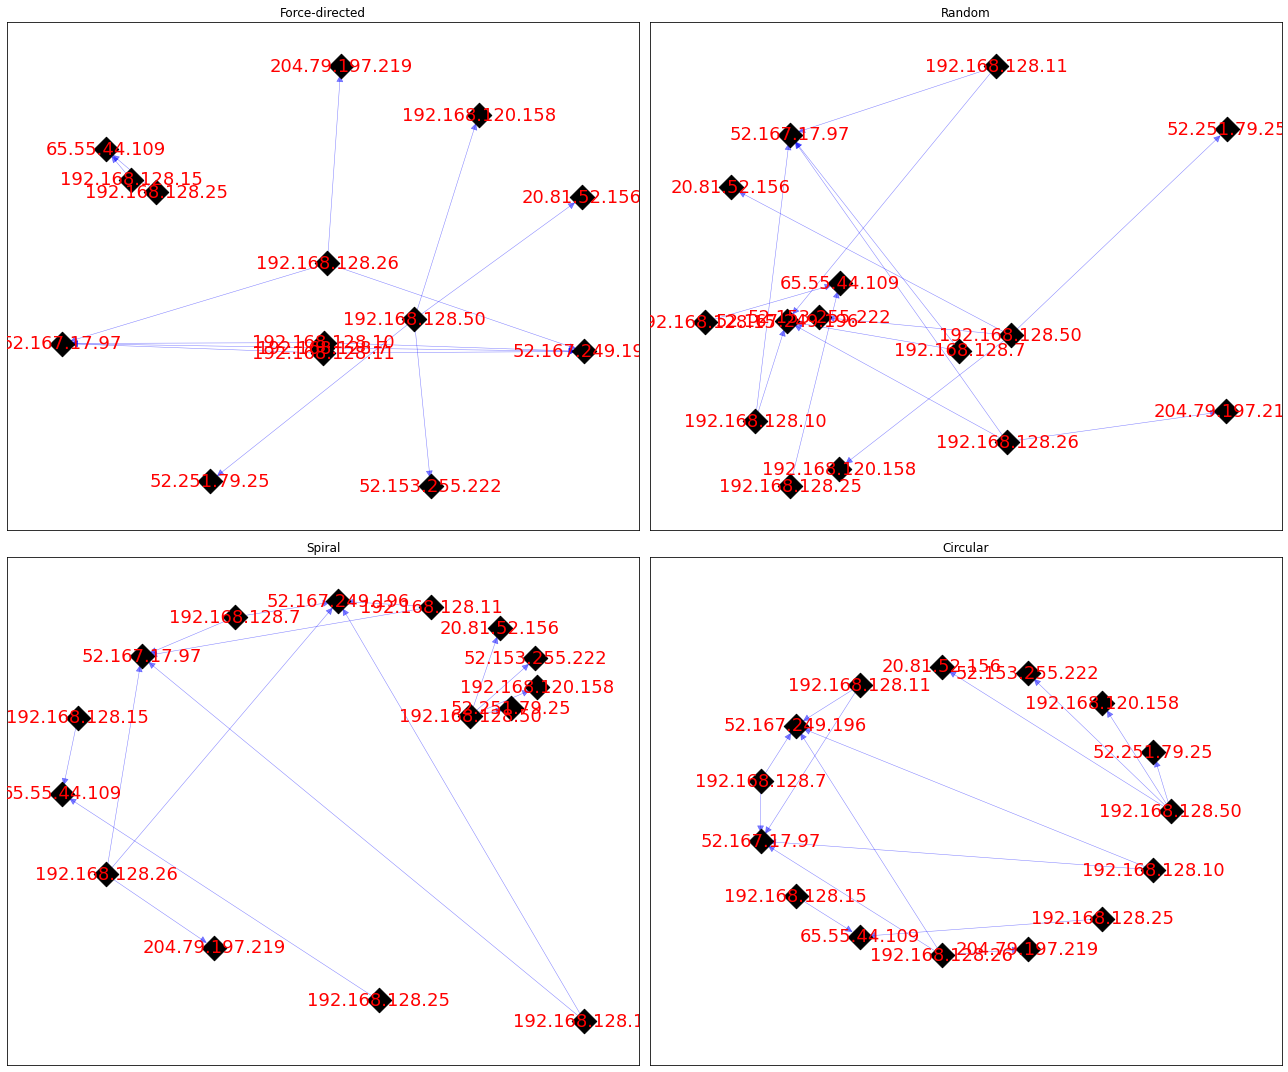

In [46]:
# Draw our graph
#Define our Graph Plot Layouts
layouts = (nx.spring_layout, nx.random_layout, nx.spiral_layout, nx.circular_layout)
title = ("Force-directed", "Random", "Spiral", "Circular")
## Create our Plots
# Create 4 subplots with the figure size based on graph size
_, plot = plt.subplots(2, 2, figsize=fig_size)
subplots = plot.reshape(1, 4)[0]
# Draw a plot for each layout
for plot, layout, title in zip(subplots, layouts, title):
    pos = layout(G)
    nx.draw_networkx_edges(G, pos, ax=plot, width=0.5, style="solid", edge_color="blue", alpha=0.5, arrows=True, arrowsize=15, arrowstyle="-|>")
    nx.draw_networkx_nodes(G, pos, ax=plot, node_color="black", node_shape="D")
    # Draw labels
    nx.draw_networkx_labels(G, pos, ax=plot, font_color="red", font_size=18)
    plot.set_title(title)
# Draw with tight layout https://matplotlib.org/tutorials/intermediate/tight_layout_guide.html
plt.gca().margins(0.20, 0.30)
plt.tight_layout()
plt.show(block=False)